<a href="https://colab.research.google.com/github/dleqhuy/Sentiment_Analysis/blob/main/03.SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dleqhuy/Sentiment_Analysis

Cloning into 'Sentiment_Analysis'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 202 (delta 99), reused 101 (delta 33), pack-reused 0
Receiving objects: 100% (202/202), 4.56 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/Sentiment_Analysis')
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
import os
import pandas as pd
import numpy as np
import modules.model as Model

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

## Công việc:
* Phần này, ta sẽ đào tạo một **Comment sentiment model**.
* Chiến lược của ta sẽ như sau:
  * **Bước 1**: Định nghĩa một vài vectorizer bằng **sklearn**.
  * **Bước 2**: Liệt kê các classifier model.
  * **Bước 3**: Với từng vectorizer đã liệt kê, sử dụng từng model classifier để đào tạo cross-validation với input là vectorizer tương ứng.
  * **Bước 4**: Lựa chọn các model và vectorizer phù hợp với dataset comment.
  * **Bước 5**: Tiến hành training lại nhưng không cross-validation.
  * **Bước 6**: Đánh giá bằng accuracy trên test data.
  * **Bước 7**: Lưu lại các model này thành file `*.pickle`.

In [5]:
data = pd.read_csv('/content/drive/MyDrive/shopee/normalize_reviews.csv')

In [6]:
Model.dataSplitSaved(data, 0.2, "/content/drive/MyDrive/shopee")

📢 Your dataset has saved at /content/drive/MyDrive/shopee.


Load training data.

In [7]:
X_train, y_train = Model.loadData("/content/drive/MyDrive/shopee/train")
display(X_train.head(), y_train.head())

,normalize_comment
0,chất gel đặc bọt tan rất lâu lưu bọt khá lâu h...
1,hàng đóng không được đẹp mùi hơi hắc nhưng cũn...
2,lọ sửa rửa mặt lép_kẹp như dùng nắp lọ không c...
3,sản_phẩm ok giao hàng nhanh nhưng chuẩn hơi lâ...
4,đểu quá


,label
0,0
1,0
2,0
3,1
4,0


In [8]:
print(len(Model.vectorizer(X_train['normalize_comment'], 'bow')[0].get_feature_names()))

4928


> **Nhận xét**:
> * Với vectorizer dầu tiên, ta thiết lập `min_df=1` mặc định của **sklearn** thì ta có tổng cộng 4,928 từ (kể cả từ ghép).
> * Số lượng này là quá lớn, sẽ khiến việc train model sẽ lâu.

Dưới đây ta lần lượt phát sinh các vectorizer bằng cả Bag of Words và TF-IDF với các `min_df` khác nhau là 5, 10 và 20.

In [9]:
vectorizers = [
    ("Bag of Words - [min_df: 5]", Model.vectorizer(X_train['normalize_comment'], 'bow', 5)),
    ("TF-IDF- [min_df: 5]", Model.vectorizer(X_train['normalize_comment'], 'tfidf', 5)),
    ("Bag of Words - [min_df: 10]", Model.vectorizer(X_train['normalize_comment'], 'bow', 10)),
    ("TF-IDF - [min_df: 10]", Model.vectorizer(X_train['normalize_comment'], 'tfidf', 10)),
    ("Bag of Words - [min_df: 20]", Model.vectorizer(X_train['normalize_comment'], 'bow', 20)),
    ("TF-IDF - [min_df: 20]", Model.vectorizer(X_train['normalize_comment'], 'tfidf', 20)),
]

In [10]:
ix = 0
print(vectorizers[ix][0],len(vectorizers[ix][1][0].get_feature_names()))

Bag of Words - [min_df: 5] 1455


> **Nhận xét**:
> * Với `min_df=5`, không gian nhỏ hơn từ  4,928 xuống còn 1,455 từ.
> * Số lượng này ổn, thích hợp để đào tạo hơn đồng thời cho ta thấy trong hơn 6,737 comment, từ rác phát sinh quá nhiều bởi chính dữ liệu và N-Grams.

In [11]:
ix = 2
print(vectorizers[ix][0],len(vectorizers[ix][1][0].get_feature_names()))

Bag of Words - [min_df: 10] 932


> **Nhận xét**:
> * Với `min_df=10`, lúc này chỉ còn hơn 932 từ và từ ghép thỏa phổ biến trên dataset comment.

In [12]:
ix = 4
print(vectorizers[ix][0],len(vectorizers[ix][1][0].get_feature_names()))

Bag of Words - [min_df: 20] 631


> **Nhận xét**:
> * Với `min_df=20`, thì chỉ còn 631, con số này thì quá nhỏ so với hơn 6,737 comment, khả năng cao vectorizer này không đủ khả năng để đại diện cho dataset comment.

Bây giờ, ta liệt kê một vài clasifier model phổ biến và dùng các vectorizer có `min_df` lần lượt là 5, 10 và 10.

Ta tiến hành train bằng cross-validation và chia training data làm 10 phần - sau đó lưu vào biến `cv` để đảm bảo dữ liệu khi cross-validation công bằng cho toàn bộ model. 

In [13]:
lst_models = [
    ('Logistic Regression', LogisticRegression()),
    ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42,probability=True)),
]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
original_models = Model.train(lst_models, vectorizers, y_train, cv)

original_models

Bag of Words - [min_df: 5]:
	Model Logistic Regression has been trained in 1.11 seconds
	Model SVC - [kernel: linear] has been trained in 178.18 seconds
TF-IDF- [min_df: 5]:
	Model Logistic Regression has been trained in 0.54 seconds
	Model SVC - [kernel: linear] has been trained in 160.23 seconds
Bag of Words - [min_df: 10]:
	Model Logistic Regression has been trained in 1.04 seconds
	Model SVC - [kernel: linear] has been trained in 176.77 seconds
TF-IDF - [min_df: 10]:
	Model Logistic Regression has been trained in 0.48 seconds
	Model SVC - [kernel: linear] has been trained in 153.18 seconds
Bag of Words - [min_df: 20]:
	Model Logistic Regression has been trained in 1.00 seconds
	Model SVC - [kernel: linear] has been trained in 178.49 seconds
TF-IDF - [min_df: 20]:
	Model Logistic Regression has been trained in 0.55 seconds
	Model SVC - [kernel: linear] has been trained in 144.79 seconds


,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,fit_time
0,TF-IDF- [min_df: 5],Logistic Regression,0.890456,0.859139,0.031317,0.001467,0.010040,0.047388
1,TF-IDF - [min_df: 10],Logistic Regression,0.884782,0.858396,0.026386,0.001174,0.009615,0.041030
2,TF-IDF- [min_df: 5],SVC - [kernel: linear],0.904343,0.855576,0.048766,0.001129,0.007835,11.712632
3,TF-IDF - [min_df: 20],Logistic Regression,0.878631,0.854685,0.023946,0.001604,0.008684,0.047777
4,TF-IDF - [min_df: 10],SVC - [kernel: linear],0.893886,0.853647,0.040239,0.001521,0.009017,11.159634
5,TF-IDF - [min_df: 20],SVC - [kernel: linear],0.885871,0.852310,0.033561,0.001626,0.009985,10.602201
6,Bag of Words - [min_df: 5],Logistic Regression,0.917075,0.851125,0.065950,0.002800,0.010379,0.102548
7,Bag of Words - [min_df: 10],Logistic Regression,0.903567,0.847116,0.056451,0.002486,0.013344,0.097355
8,Bag of Words - [min_df: 20],Logistic Regression,0.892188,0.843849,0.048339,0.002098,0.014407,0.092970
9,Bag of Words - [min_df: 20],SVC - [kernel: linear],0.899708,0.837765,0.061943,0.001758,0.011796,14.694676


> **Nhận xét**:
> * Ta thấy 5 model đầu tiên có `train_acc` và `test_acc` cao và không chênh lệch nhiều
> * Ở các model này, vectorizer phổ biến là TF-IDF có `min_df=5`.

Bây giờ, ta sẽ đào tạo lại các model trên toàn bộ training data và load dữ liệu test data lên để tiến hành kiểm thử.

In [15]:
X_test, y_test = Model.loadData("/content/drive/MyDrive/shopee/test")

tfidf_test_comment = vectorizers[1][1][0].transform(X_test['normalize_comment'])

In [16]:
best_models = Model.evaluation(lst_models, vectorizers[1][1][1], y_train, tfidf_test_comment, y_test)

best_models

,model,train_acc,test_acc
0,SVC - [kernel: linear],0.904705,0.852819
1,Logistic Regression,0.890159,0.851039


> **Nhận xét**:
> * Có thể thấy các model hoạt động ổn định tuy nhiên chênh lệch không lớn giữa cả hai. 

Bây giờ ta sẽ lưu các model này cùng vectorizer TF-IDF `min_df=5` vào cùng một `SentimentModel`.

In [17]:
logistic_model = Model.SentimentModel(lst_models[0][1], vectorizers[1], y_train)
svc_model = Model.SentimentModel(lst_models[1][1], vectorizers[1], y_train)


print(logistic_model.info())
print(svc_model.info())

LogisticRegression()
None
SVC(kernel='linear', probability=True, random_state=42)
None


Tiếp theo, ta sẽ đánh giá các model trên test data và training data và thực hiện trực quan hóa kết quả đánh giá.

              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      3358
    Positive       0.89      0.89      0.89      3379

    accuracy                           0.89      6737
   macro avg       0.89      0.89      0.89      6737
weighted avg       0.89      0.89      0.89      6737



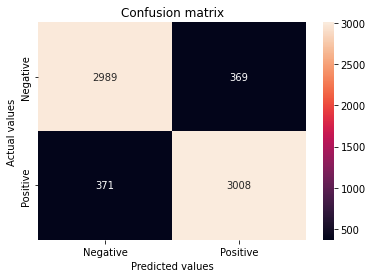

              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85       853
    Positive       0.85      0.85      0.85       832

    accuracy                           0.85      1685
   macro avg       0.85      0.85      0.85      1685
weighted avg       0.85      0.85      0.85      1685



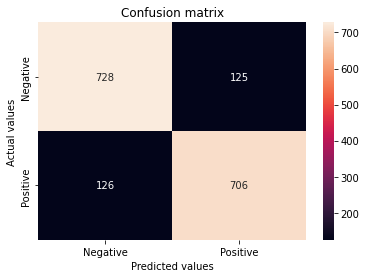

,input,output_proba,output_class
0,chất gel đặc bọt tan rất lâu lưu bọt khá lâu h...,"(0.6259896009145938, 0.3740103990854062)",0
1,hàng đóng không được đẹp mùi hơi hắc nhưng cũn...,"(0.8426643779972195, 0.1573356220027805)",0
2,lọ sửa rửa mặt lép_kẹp như dùng nắp lọ không c...,"(0.9645199558435118, 0.035480044156488186)",0
3,sản_phẩm ok giao hàng nhanh nhưng chuẩn hơi lâ...,"(0.027050041505480737, 0.9729499584945193)",1
4,đểu quá,"(0.7524807508460098, 0.24751924915399015)",0


,input,output_proba,output_class
0,sản_phẩm tốt giá ok,"(0.02808883726787692, 0.9719111627321231)",1
1,kết_cấu típ công_dụng rữa mặt mùi hương hơi hô...,"(0.7457557360981663, 0.25424426390183374)",0
2,phục_vụ tốt giao thiếu món nhưng bù cho khá hà...,"(0.6483816834177699, 0.3516183165822301)",0
3,dùng ngày mới quay đánh_giá sản_phẩm_cấp ẩm cự...,"(0.02367545896351919, 0.9763245410364808)",1
4,hàng tốt giao hàng nhanh lắm must try,"(0.031611042405654266, 0.9683889575943457)",1


In [18]:
# Logistic model
y_train_pred = logistic_model.predict(X_train['normalize_comment'])
y_test_pred = logistic_model.predict(X_test['normalize_comment'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

display(y_train_pred.head(), y_test_pred.head())

              precision    recall  f1-score   support

    Negative       0.91      0.90      0.90      3358
    Positive       0.90      0.91      0.91      3379

    accuracy                           0.90      6737
   macro avg       0.90      0.90      0.90      6737
weighted avg       0.90      0.90      0.90      6737



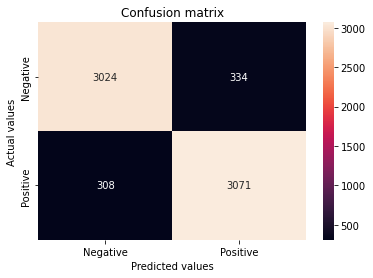

              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85       853
    Positive       0.84      0.86      0.85       832

    accuracy                           0.85      1685
   macro avg       0.85      0.85      0.85      1685
weighted avg       0.85      0.85      0.85      1685



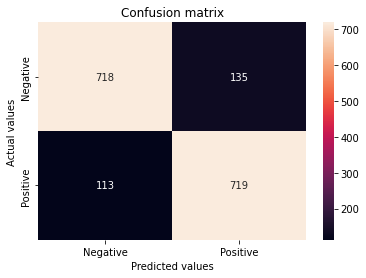

,input,output_proba,output_class
0,chất gel đặc bọt tan rất lâu lưu bọt khá lâu h...,"(0.8240992591366194, 0.1759007408633805)",0
1,hàng đóng không được đẹp mùi hơi hắc nhưng cũn...,"(0.8804018564401097, 0.11959814355989007)",0
2,lọ sửa rửa mặt lép_kẹp như dùng nắp lọ không c...,"(0.9861501041807401, 0.013849895819259788)",0
3,sản_phẩm ok giao hàng nhanh nhưng chuẩn hơi lâ...,"(0.012433090994722834, 0.9875669090052772)",1
4,đểu quá,"(0.8670840066340911, 0.13291599336590879)",0


,input,output_proba,output_class
0,sản_phẩm tốt giá ok,"(0.024238182954362357, 0.9757618170456376)",1
1,kết_cấu típ công_dụng rữa mặt mùi hương hơi hô...,"(0.8162693023943742, 0.18373069760562563)",0
2,phục_vụ tốt giao thiếu món nhưng bù cho khá hà...,"(0.7029759616248464, 0.2970240383751536)",0
3,dùng ngày mới quay đánh_giá sản_phẩm_cấp ẩm cự...,"(0.007580543735938891, 0.9924194562640609)",1
4,hàng tốt giao hàng nhanh lắm must try,"(0.022023742925972478, 0.9779762570740275)",1


In [19]:
# SVC model
y_train_pred = svc_model.predict(X_train['normalize_comment'])
y_test_pred = svc_model.predict(X_test['normalize_comment'])

Model.confusionMatrix(y_train, y_train_pred['output_class'])
Model.confusionMatrix(y_test, y_test_pred['output_class'])

display(y_train_pred.head(), y_test_pred.head())

> **Nhận xét**:
> * Có thể thấy, khả năng dự đoán còn kém trên các class positive. Nhiều comment thực chất là positive nhưng lại bị dự đoán nhầm sang negative.
> * Khả năng dự đoán trên class negative tốt hơn ở các model. Điều này có thể là do variance error. Ở project một, ta đã tách các comment có 4 đến 5 sao vào nhóm positive và còn lại thuộc class negative. Tuy nhiên điều này có thể sai:
>   * Thực chất có các comment 3 sao đôi khi là các khách hàng trung bình, họ không thích cũng như không ghét sản phẩm, lúc này bài toán của chúng ta có thể tách thành 3 class là **positive**, **neutral** và **negative** để hị vọng khả năng dự đoán của model tốt hơn.
>   * Do noise sample, lí do là có những comment măc dù về ngữ nghĩa là positive nhưng nó lại thuộc nhóm negative và ngược lại. Tức ta không tiền xử lí dữ liệu tốt. Tuy nhiên ta khó lòng giải quyết vì nó phụ thuộc vào đánh giá chủ quan của con người. Nhưng với khả năng hiện tại nhóm khó khắc phục được lỗi này.

Bây giờ ta sẽ lưu lại các model này cùng với vectorizer TF-IDF `min_df=5`. Ta cũng cần lưu lại file tập N-Grams các từ ghép tổ hợp từ 2, 3 và 4 từ để có thể tiến hành transform khi có dữ liệu mới. 

In [20]:
Model.saveByPickle(svc_model, "/content/drive/MyDrive/shopee/models/svc_model_comments.pickle")
Model.saveByPickle(logistic_model, "/content/drive/MyDrive/shopee/models/logistic_model_comments.pickle")

<modules.model.SentimentModel object at 0x7faebe5d3190> has been saved at /content/drive/MyDrive/shopee/models/svc_model_comments.pickle.
<modules.model.SentimentModel object at 0x7faebe577950> has been saved at /content/drive/MyDrive/shopee/models/logistic_model_comments.pickle.
